In [1]:
import csv
import subprocess
import getpass
import os
import gzip
from os import listdir
from os.path import isfile, join
from SciServer import Authentication

myUserName = Authentication.getKeystoneUserWithToken(Authentication.getToken()).userName
passwd = getpass.getpass('Password for ' + myUserName + ': ')
userstring = "username=" + myUserName + ",workgroup=win,uid=idies,password=" + passwd
projectname = input("Please enter the name of your SAFE Desktop project folder : ") 
dir = "//cloud.nas.jh.edu/sddesktop$/" + projectname
devnull = open(os.devnull, 'w')
subprocess.run(["sudo", "mkdir", "/home/idies/workspace/SAFE"], capture_output=False)
subprocess.run(["sudo", "chown", "idies:idies", "/home/idies/workspace/SAFE/"], capture_output=False)
try:
    subprocess.run(["sudo", "mount", "-t", "cifs", dir, "/home/idies/workspace/SAFE/", "-o", userstring], stdout=devnull, stderr=devnull)
except FileNotFoundError as e:
    print(e) 

Password for mkim239:  ········
Please enter the name of your SAFE Desktop project folder :  LCICM


mkdir: cannot create directory '/home/idies/workspace/SAFE': File exists


In [2]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [5]:
combined_features = pd.read_csv("SAFE/complete_features.csv")
combined_features_cleaned = combined_features.drop(["hf_original", "hf_type_original"], axis = 1)
df_cleaned = add_constant(combined_features_cleaned)

In [6]:
# impute nan/inf values
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in df_cleaned.columns:
    df_cleaned.fillna({col: df_cleaned[col].mean()}, inplace=True)

vif_data = pd.DataFrame()
vif_data["feature"] = df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(df_cleaned.values, i) for i in range(df_cleaned.shape[1])]
vif_data = vif_data.iloc[1:, :]  

/home/idies/miniconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/idies/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [7]:
# VIF threshold visualization
vif_10 = sum(vif_data["VIF"] > 10)
print("Between 10 and inf: " + str(vif_10))
vif_5 = sum((vif_data["VIF"] > 5) & (vif_data["VIF"] < 10))
print("Between 5 and 10: " + str(vif_5))
print("Between 0 and 5: " + str(len(vif_data["VIF"]) - vif_10 - vif_5))
print(vif_data[(vif_data["VIF"] > 5) & (vif_data["VIF"] < 10)])
print(vif_data[(vif_data["VIF"] >= 0) & (vif_data["VIF"] < 5)])

Between 10 and inf: 348
Between 5 and 10: 24
Between 0 and 5: 34
             feature       VIF
25    sd_ratio_lead1  7.005275
74   tri_index_lead3  6.567674
100  tri_index_lead4  6.313031
126  tri_index_lead5  7.446032
152  tri_index_lead6  8.917885
178  tri_index_lead7  6.468779
233   sd_ratio_lead9  6.706899
259  sd_ratio_lead10  8.399832
314               HR  5.471591
326       Tpeak_Tend  7.174985
368         Q_Amp_V3  7.483573
370         S_Amp_V3  9.924000
371         T_Amp_V3  6.074263
373         Q_Amp_V4  8.714880
374         R_Amp_V4  7.227923
376         T_Amp_V4  8.425305
378         Q_Amp_V5  6.778815
381         T_Amp_V5  9.372534
383         Q_Amp_V6  5.083591
384         R_Amp_V6  7.822216
385         S_Amp_V6  5.004566
386         T_Amp_V6  6.117776
391            p_end  5.095091
396         qrs_axis  5.137294
                               feature       VIF
77                      sd_ratio_lead3  4.019412
103                     sd_ratio_lead4  4.092968
129          

In [8]:
import csv
feature_good_vif = vif_data[vif_data["VIF"] <= 10]
feature_list = feature_good_vif["feature"].tolist()
print(feature_list)

# exporting to shared directory
with open ("SAFE/vif_features_list.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(feature_list)

['sd_ratio_lead1', 'tri_index_lead3', 'sd_ratio_lead3', 'tri_index_lead4', 'sd_ratio_lead4', 'tri_index_lead5', 'sd_ratio_lead5', 'tri_index_lead6', 'sd_ratio_lead6', 'tri_index_lead7', 'sd_ratio_lead7', 'sd_ratio_lead9', 'sd_ratio_lead10', 'RR_Int', 'HR', 'Tpeak_Tend', 'P_Amp_V1', 'Q_Amp_V1', 'R_Amp_V1', 'S_Amp_V1', 'T_Amp_V1', 'P_Amp_V2', 'Q_Amp_V2', 'R_Amp_V2', 'S_Amp_V2', 'T_Amp_V2', 'P_Amp_V3', 'Q_Amp_V3', 'R_Amp_V3', 'S_Amp_V3', 'T_Amp_V3', 'P_Amp_V4', 'Q_Amp_V4', 'R_Amp_V4', 'T_Amp_V4', 'P_Amp_V5', 'Q_Amp_V5', 'T_Amp_V5', 'P_Amp_V6', 'Q_Amp_V6', 'R_Amp_V6', 'S_Amp_V6', 'T_Amp_V6', 'subject_id_original', 'age', 'p_end', 'qrs_axis', 't_axis', 'HDL', 'tot_cholesterol', 'glucose', 'bnp', 'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'Heart Rate', 'gender', 'race']


In [9]:
df = pd.read_csv("SAFE/complete_features.csv")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
X = df[feature_list]
y = df["hf_original"]
print(X.shape)

(18327, 57)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [29]:
# for hyperparameter tuning
param_grid_log = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", "None"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "fit_intercept": [False, True],
    "max_iter": [300, 350, 400, 450, 500, 550, 600]
}

param_grid_rf = {
    "n_estimators": np.arange(50, 350, 50),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(2, 20, 1),
    "min_samples_split": np.arange(0, 1.05, 0.05),
    "min_samples_leaf": np.arange(0, 1.05, 0.05),
    "min_weight_fraction_leaf": np.arange(0, 0.5, 0.05),
    "max_features": ["sqrt", "log2", None],
    "max_leaf_nodes": [None, 10, 20, 30],
    "bootstrap": [True, False],
    "oob_score": [False, True],
    "max_samples": np.arange(0, 1.05, 0.05),
    "class_weight": [None, "balanced", "balanced_subsample"]
}

param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "degree": [2, 3, 4, 5]
}

In [12]:
# making a function to produce AUROC given model
def plot_auroc(model):
    # calculate AUROC + AUPRC
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    prob_train = model.predict_proba(X_train_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, prob_train)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve test (area = %0.2f)" % auc(fpr, tpr))
    plt.plot(fpr_train, tpr_train, color="darkgreen", lw=2, label="ROC curve train (area = %0.2f)" % auc(fpr_train, tpr_train))
    
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")


In [13]:
# making a function to produce AUROC given model
from sklearn.metrics import precision_recall_curve
def plot_auprc(model):
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    prob_train = model.predict_proba(X_train_scaled)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, prob_test)
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, prob_train)
    
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color="darkorange", lw=2, label="AUPRC (area = %0.2f)" % auc(recall, precision))
    plt.plot(recall, precision, color="darkgreen", lw=2, label="AUPRC train (area = %0.2f)" % auc(recall_train, precision_train))    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Recall Precision Curve")
    plt.legend(loc="lower right")

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
def calc_f1(model):
    y_pred = model.predict(X_test_scaled)
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    cm= confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

In [15]:
# TUNING FOR RANDOM FOREST
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
rf_model = RandomForestClassifier()

In [17]:
grid_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=3, verbose=1, n_jobs=-1, n_iter = 5000, scoring = "roc_auc")
grid_search_rf.fit(X_train_scaled, y_train)
print(grid_search_rf.best_params_)

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits
{'oob_score': False, 'n_estimators': 150, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_samples': 0.9500000000000001, 'max_leaf_nodes': 20, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


F1 Score: 0.49743451255738597
Sensitivity: 0.7009132420091324
Specificity: 0.6492234169653525


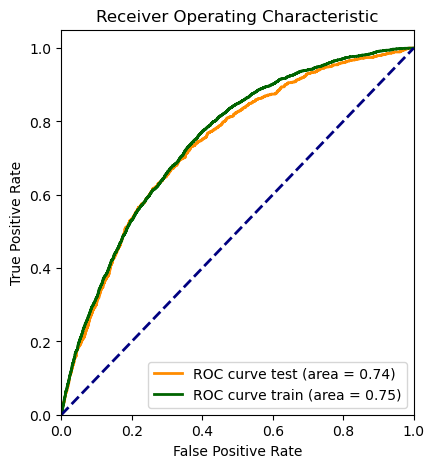

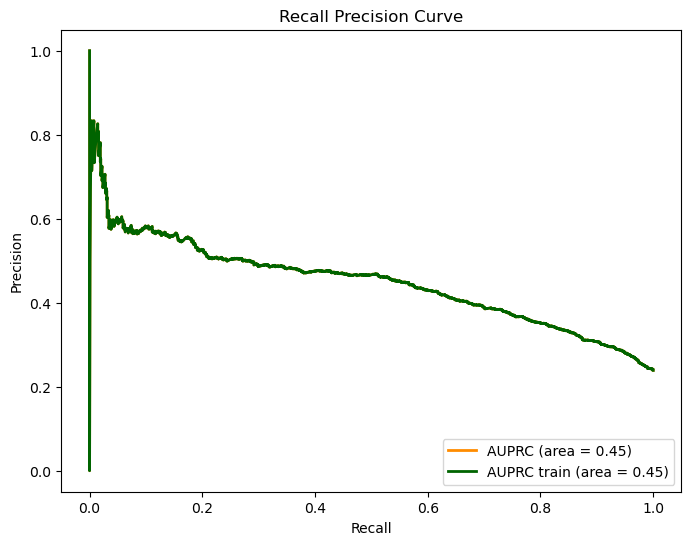

In [18]:
# show performance
plot_auroc(grid_search_rf.best_estimator_)
plot_auprc(grid_search_rf.best_estimator_)
calc_f1(grid_search_rf.best_estimator_)

In [22]:
# TUNING FOR LOG REGRESSION
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
log_model = LogisticRegression()

In [30]:
grid_search_log = RandomizedSearchCV(estimator=log_model, param_distributions=param_grid_log, cv=3, verbose=1, n_jobs=-1, n_iter = 5000, scoring = "roc_auc")
grid_search_log.fit(X_train_scaled, y_train)
print(grid_search_log.best_params_)

Fitting 3 folds for each of 2240 candidates, totalling 6720 fits


/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/idies/miniconda3/lib/python3.9/site-packages/sklearn/linear_mode

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 550, 'fit_intercept': True, 'C': 0.01}


F1 Score: 0.2587123449497933
Sensitivity: 0.16666666666666666
Specificity: 0.961768219832736


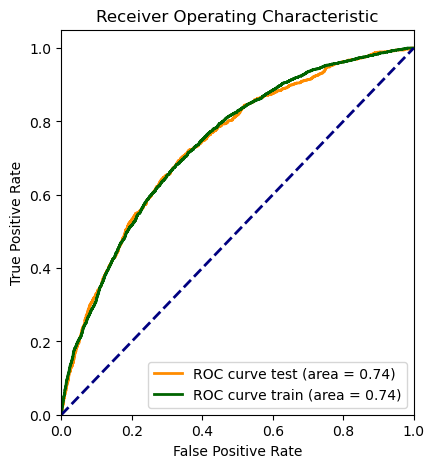

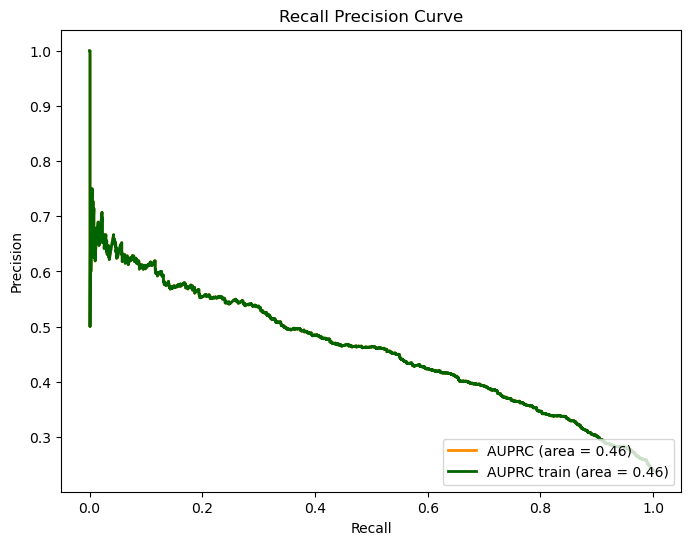

In [31]:
# show performance
plot_auroc(grid_search_log.best_estimator_)
plot_auprc(grid_search_log.best_estimator_)
calc_f1(grid_search_log.best_estimator_)